In [31]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
# import xgbfir

from tqdm import tqdm_notebook, tnrange

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# from boruta import BorutaPy

In [65]:
np.random.seed(42)

In [32]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [55]:
burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

burst_params = [ ] + burst_oscore_cols

spiketrain_params = ['AI', 'burst_spike_percent', 'cv', 'firing_rate', 'frequency_variance', 'isi_mean', 'isi_median', 'isi_std',
                    'isi_larger_than_mean', 'kurtoisis', 'skewness', 'lv', 'nu', 
                     'oscore_12.0_20.0', 'oscore_20.0_30.0', 'oscore_3.0_8.0', 'oscore_30.0_60.0',
                     'oscore_60.0_90.0', 'oscore_8.0_12.0','interburst_interval', 'mean_burst_len', 'ratio_burst_time',
                    'mean_isi_in_burst', 'median_isi_in_burst', 'mean_spikes_in_burst']

recording_params = ['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length']
useless_params = ['burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio']

In [56]:
data_awake = pd.read_csv('data/awake_ps.csv')
# data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length',
#                              'burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

data_awake = data_awake.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})
data_awake = data_awake[spiketrain_params + burst_params  + recording_params + ['patient']]

# for c in burst_oscore_cols:
#     data_awake = data_awake[data_awake[c] > 0.]
#     data_awake = data_awake.drop([c], axis=1)

data_awake = data_awake.drop(burst_oscore_cols, axis=1)

data_awake = data_awake[data_awake['mean_spikes_in_burst'] > 0]
data_awake['mean_burst_len'] = data_awake['mean_burst_len'].astype(float)

In [57]:
data_sleep = pd.read_excel('data/sleep_ps.xls')
# data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length',
#                              'burst_index', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

data_sleep = data_sleep.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})

data_sleep = data_sleep[spiketrain_params + burst_params + recording_params + ['patient']]

# for c in burst_oscore_cols:
#     data_sleep = data_sleep[data_sleep[c] > 0.]
#     data_sleep = data_sleep.drop([c], axis=1)

data_sleep = data_sleep.drop(burst_oscore_cols, axis=1)

data_sleep = data_sleep[data_sleep['mean_spikes_in_burst'] > 0]
data_sleep['mean_burst_len'] = data_sleep['mean_burst_len'].astype(float)

In [58]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)

data = data[data['filter_length'] > 5]
data = data.drop(recording_params, axis=1)

patients = data['patient']
data = data.drop(['patient'], axis=1)

# old_cols = list(data.columns.values)
# data.columns = list(range(1, len(old_cols) + 1))

# spiketrain_idx = [old_cols.index(p) + 1 for p in spiketrain_params]
# burst_idx = [old_cols.index(p) + 1 for p in burst_params]

In [59]:
data = data[data['mean_spikes_in_burst'] > 0]
print(data.shape)

(341, 26)


In [9]:
# data = data.drop([old_cols.index(p) + 1 for p in useless_params], axis=1)
# print(data.shape)

In [12]:
data.to_csv('all_params.csv', index=False)
# data[spiketrain_idx + [data.columns.values[~0]]].to_csv('spiketrain_params.csv', index=False)
# data[burst_idx + [data.columns.values[~0]]].to_csv('burst_params.csv', index=False)

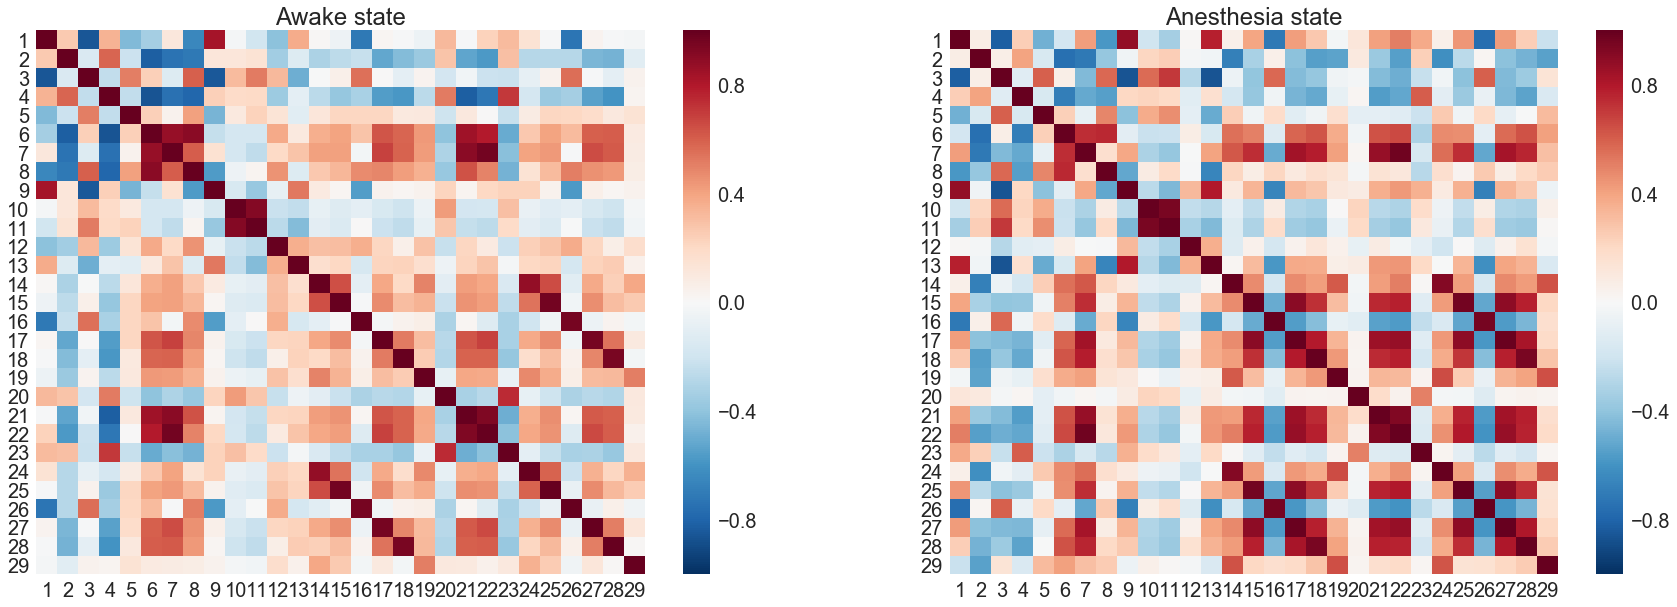

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30,10))
sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1).corr(), ax=ax1)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1).corr(), ax=ax2)
ax1.set_title('Awake state')
ax2.set_title('Anesthesia state')

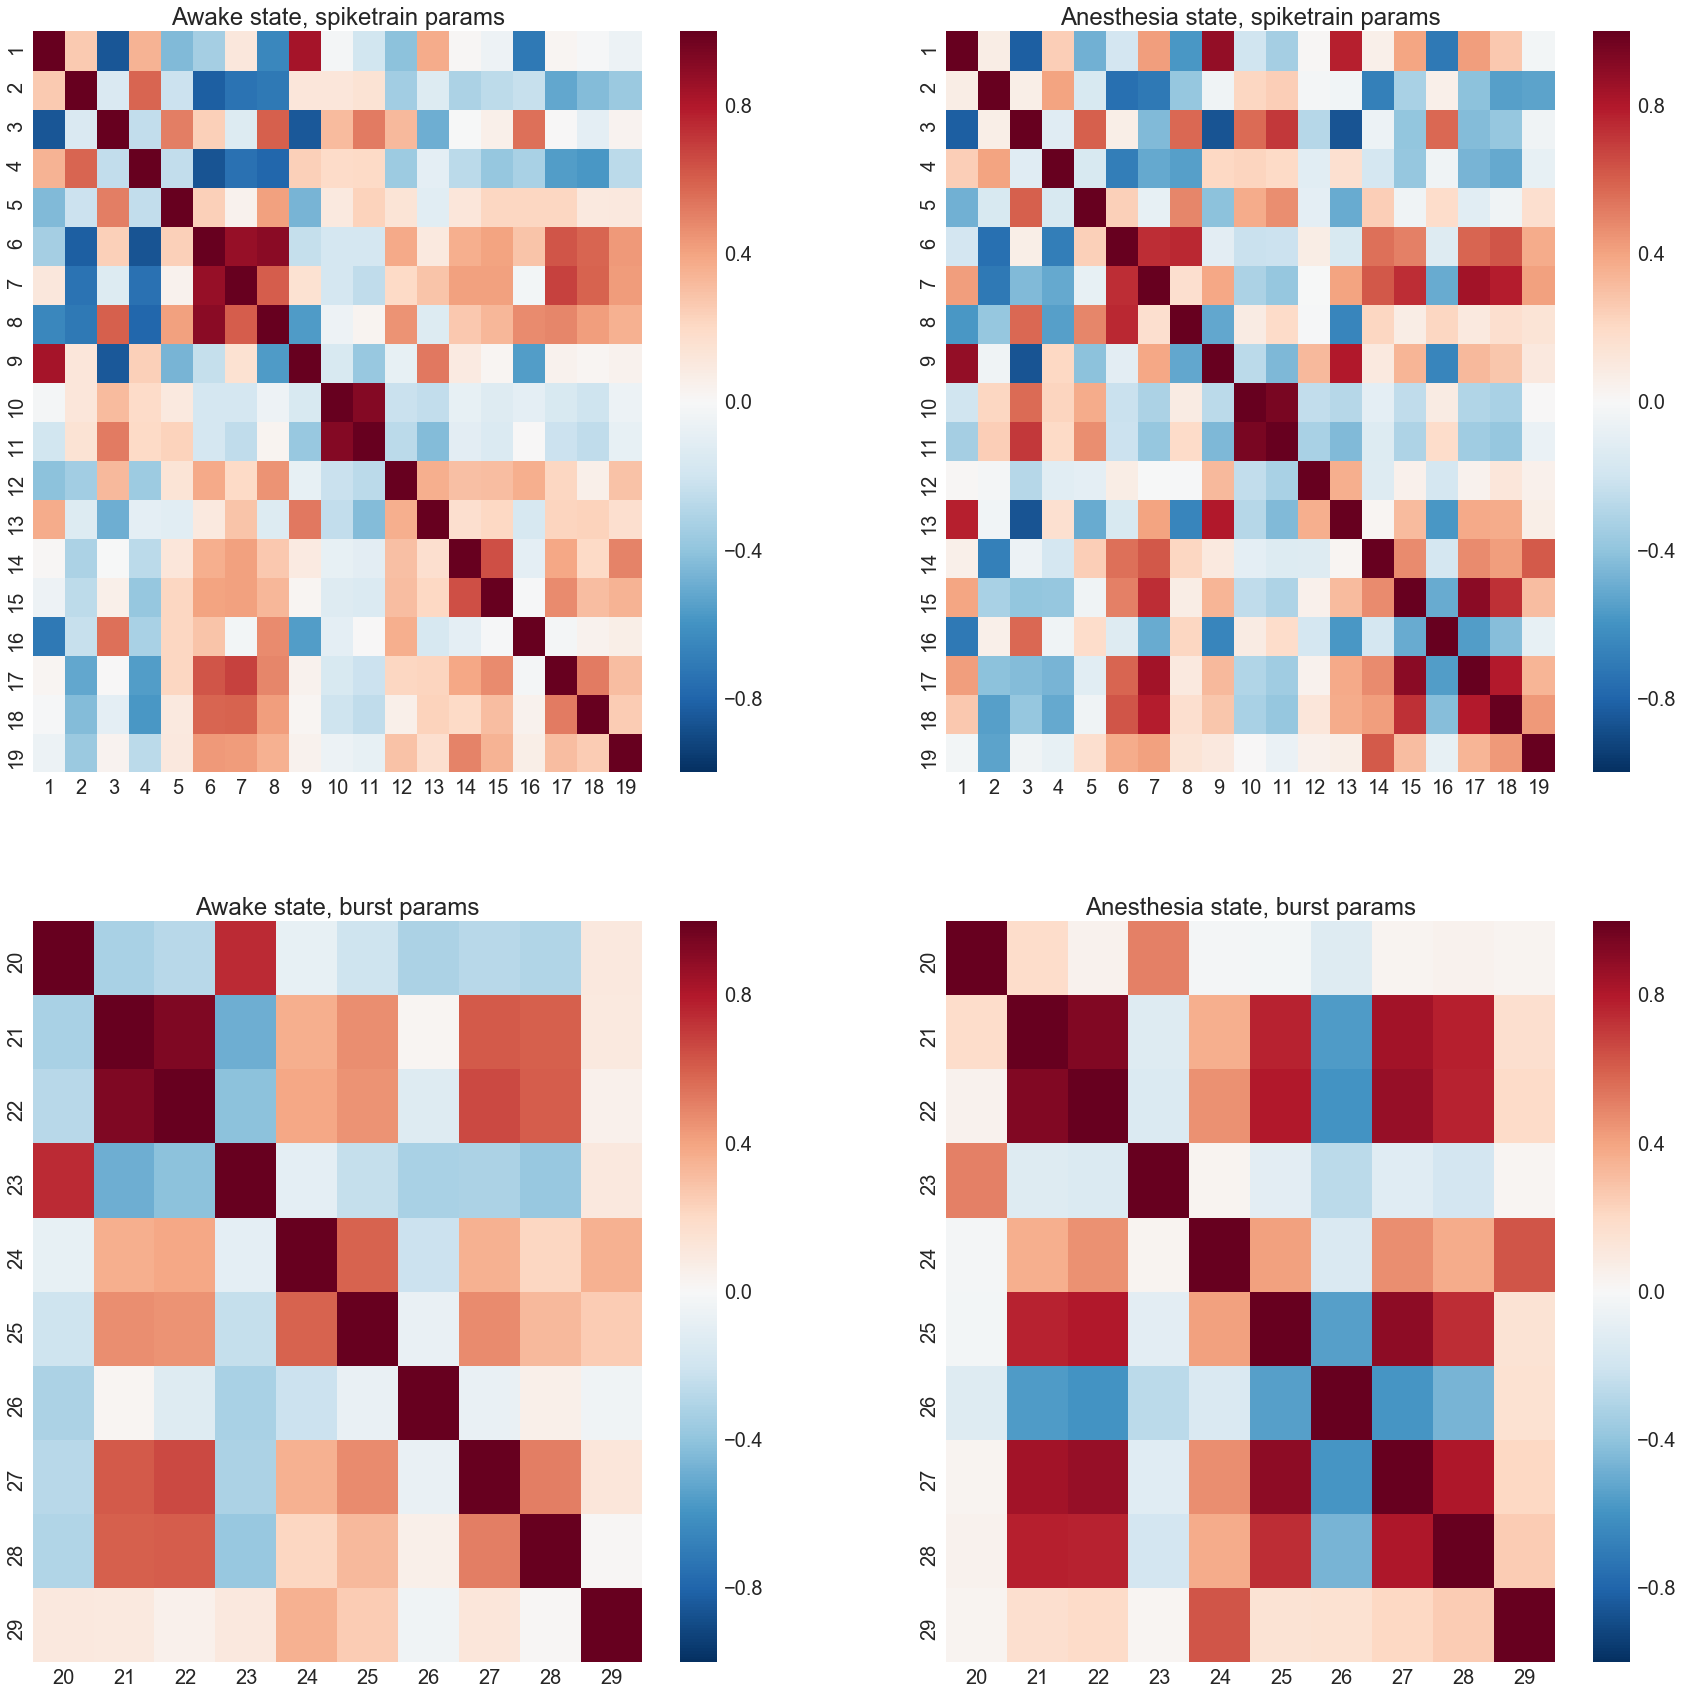

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(30,30))

sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1)[spiketrain_idx].corr(), ax=ax1)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1)[spiketrain_idx].corr(), ax=ax2)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1)[burst_idx].corr(), ax=ax3)
sns.heatmap(data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1)[burst_idx].corr(), ax=ax4)

ax1.set_title('Awake state, spiketrain params')
ax2.set_title('Anesthesia state, spiketrain params')
ax3.set_title('Awake state, burst params')
ax4.set_title('Anesthesia state, burst params')

In [73]:
def simple_cv(X, y, patients, model_type, params=None, plot=True, ax=None):
    
    if model_type == 'xgb':
        model = xgb.XGBClassifier(**params)
    elif model_type == 'linear':
        model = LogisticRegression()
    elif model_type == 'rf':        
        model = RandomForestClassifier(**params)

    acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    
    if plot:
        if ax is None:
            f, ax = plt.subplots(figsize=(15,10))
        
        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

    return acc, auc_score

In [47]:
def patient_cv(X, y, patients, model_type, params=None, plot=True, ax=None):
    all_idx = np.array(range(X.shape[0]))
    
    names = set(patients)
    
    X = X.as_matrix()
    y = np.array(y)
        
    y_pred = np.zeros(y.shape[0], dtype=int)
    probs = np.zeros(y.shape[0], dtype=float)
    acc = list()
    
    for p in names:
        test_idx = np.where(patients == p)
        train_idx = np.delete(all_idx, test_idx, 0)
        
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        if model_type == 'xgb':
            model = xgb.XGBClassifier(**params)
        elif model_type == 'linear':
            model = LogisticRegression()
        elif model_type == 'rf':
            model = RandomForestClassifier(**params)

        model.fit(X_train, y_train)
        
        curr_pred = model.predict(X_test)
        
        y_pred[test_idx] = curr_pred
        probs[test_idx] = model.predict_proba(X_test)[:,1]
        
        acc.append(accuracy_score(y_test, curr_pred))
        
    acc = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        if ax is None:
            f, ax = plt.subplots(figsize=(15,10))
        
        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
    return acc, auc_score

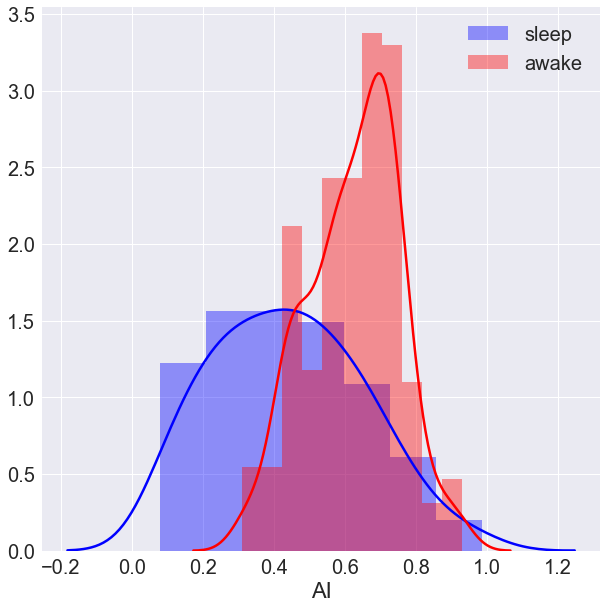

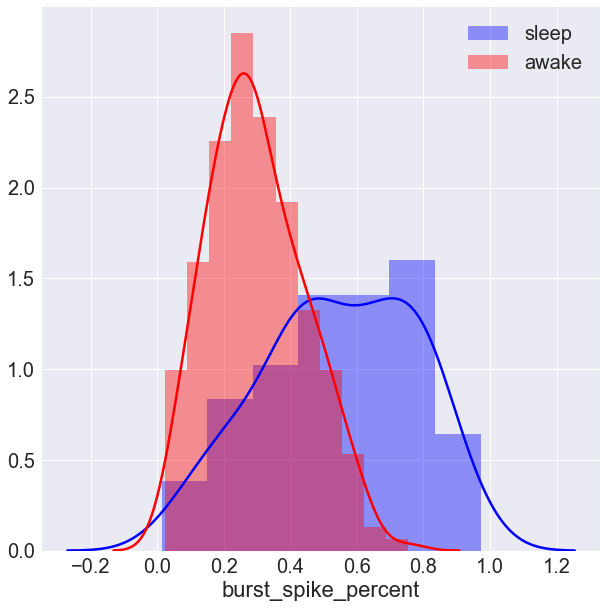

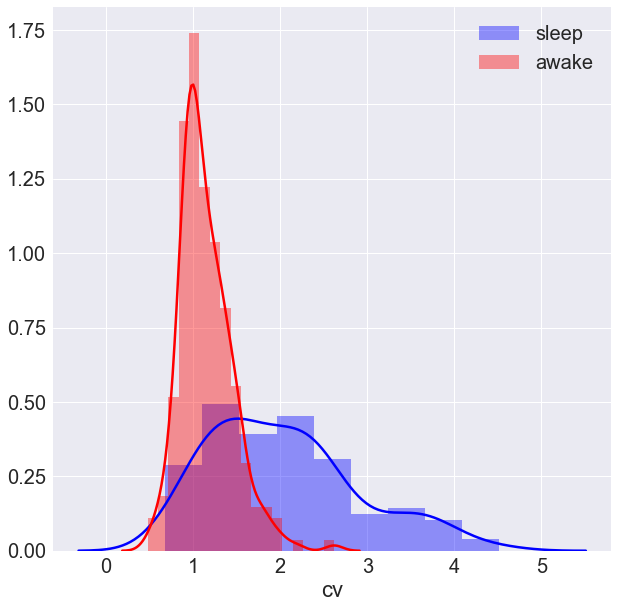

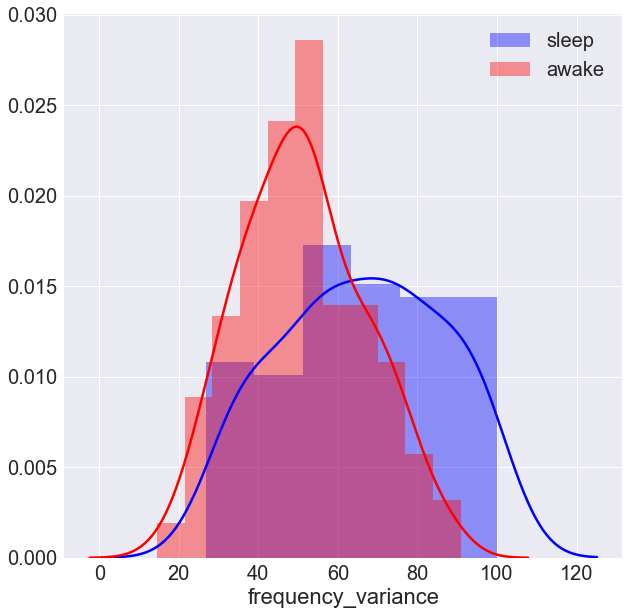

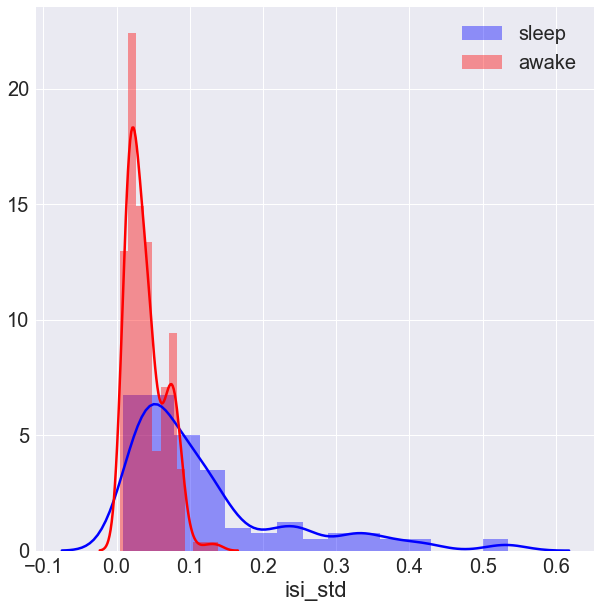

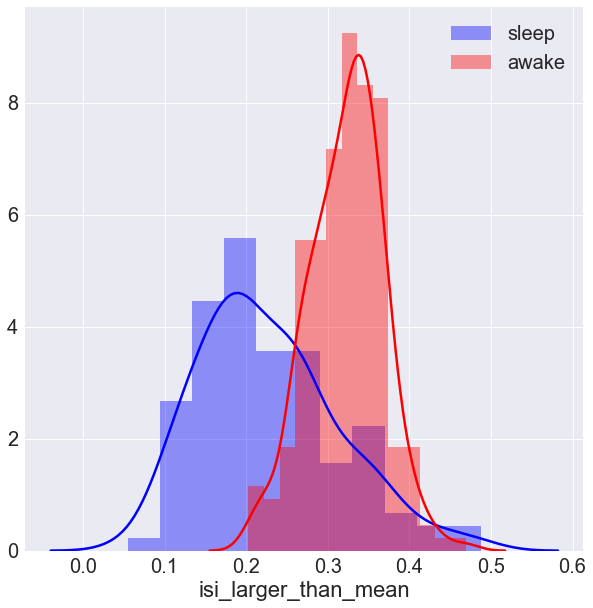

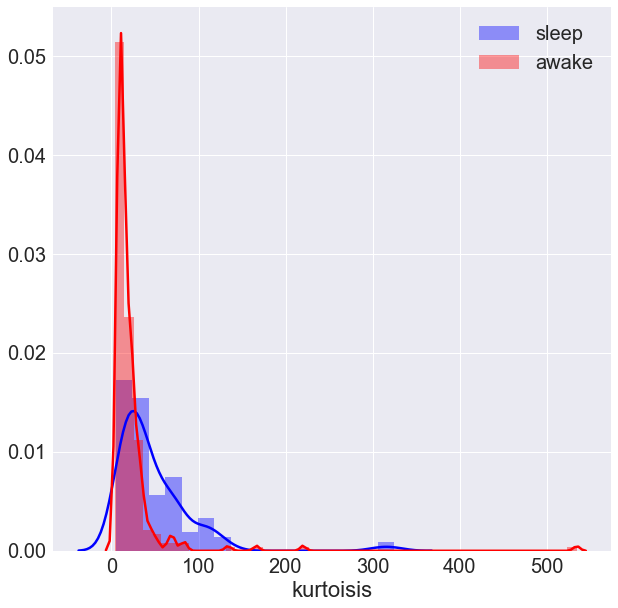

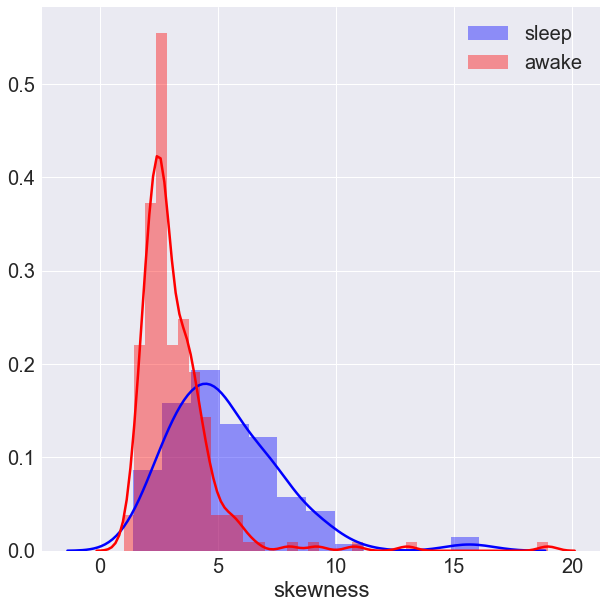

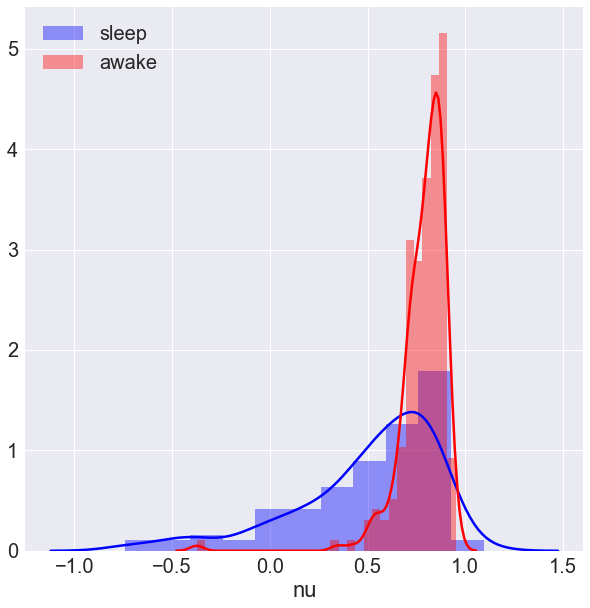

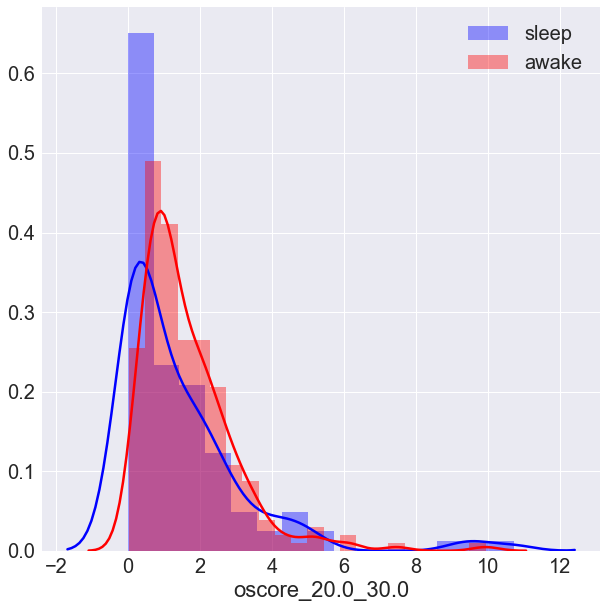

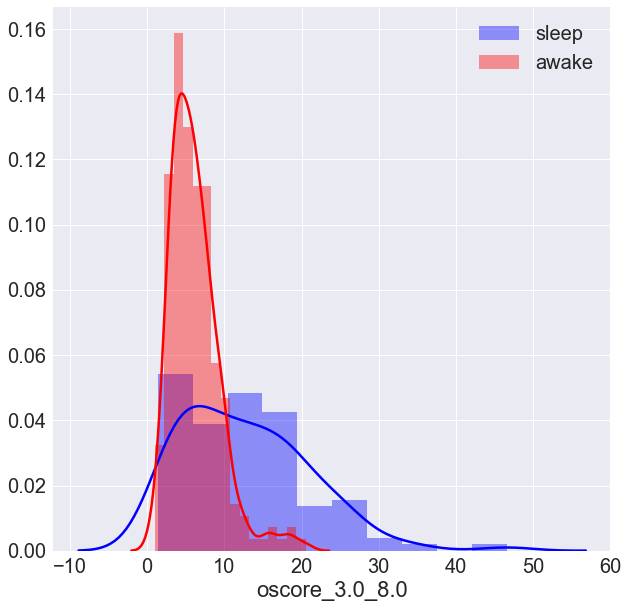

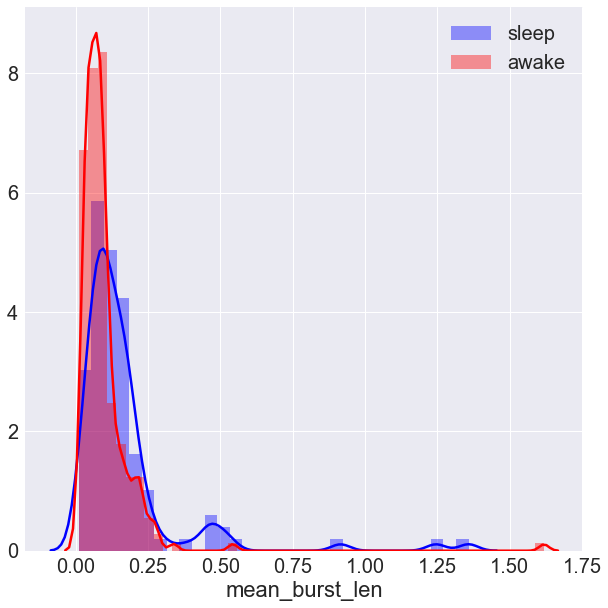

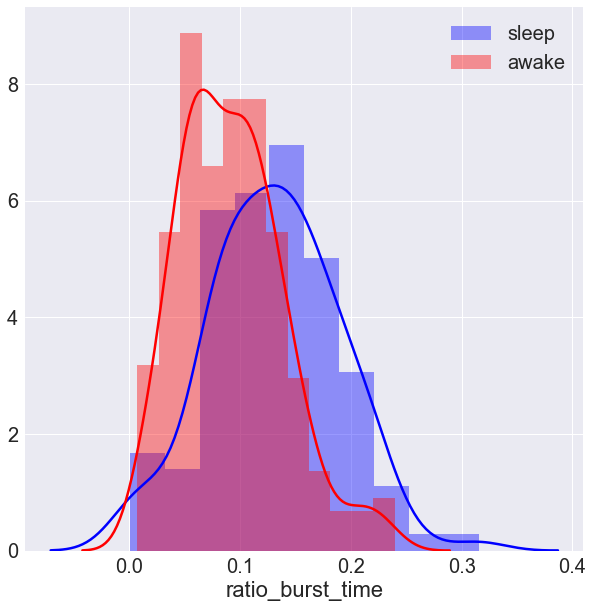

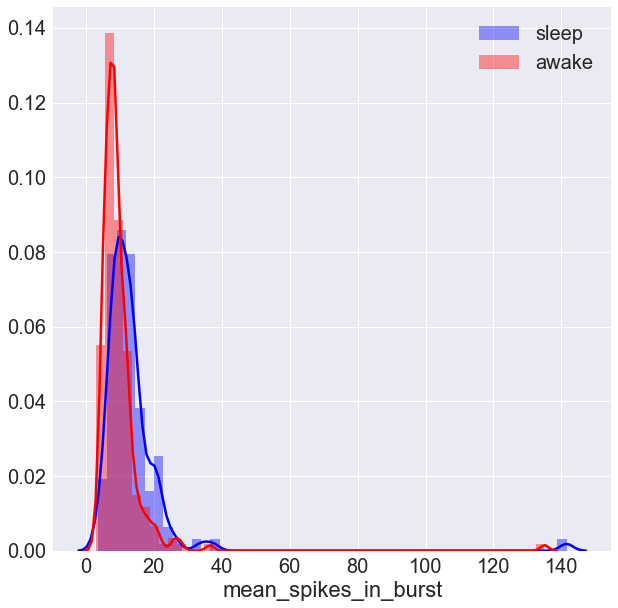

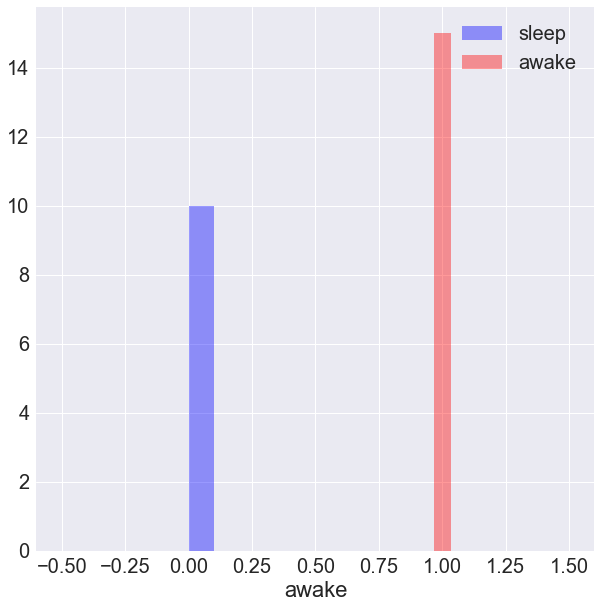

In [60]:
for c in data.columns.values:
    sleep_data = data[data['awake'] == 0][c]
    awake_data = data[data['awake'] == 1][c]
        
#     print(data[data['awake'] == 0].shape)
#     stat, pval = sp.stats.ttest_ind_from_stats(np.mean(sleep_data), np.var(sleep_data), len(sleep_data),
#                                                np.mean(awake_data), np.var(awake_data), len(awake_data))
    stat, pval = sp.stats.ks_2samp(sleep_data, awake_data)
    if pval < 1e-5:
        plt.figure(figsize=(10,10))
        sns.distplot(sleep_data, color='blue', label='sleep')
        sns.distplot(awake_data, color='red', label='awake')
        plt.legend()


In [50]:
def fix_params(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
#     params['max_features'] = int(params['max_features'])
    
    return params

def score(X, y, patients, pbar, cv_type, model_type, metric, params):
    params = fix_params(params)
    
    if cv_type == 'patient':
        accuracy, auc = patient_cv(X, y, patients, model_type, params, plot=False)
    elif cv_type == 'simple':
        accuracy, auc = simple_cv(X, y, patients, model_type, params, plot=False)
    else:
        raise RuntimeError('Uknown cv type!')
    
    if metric == 'auc':
        loss = -auc
    elif metric == 'accuracy':
        loss = -accuracy
    else:
        raise RuntimeError('Uknown metric for scoring!')
        
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}

def optimize(X, y, patients, trials, cv_type='simple', model_type='xgb', metric='accuracy', max_evals=250):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#              'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#              'max_features': hp.quniform('max_features', 1, X.shape[1], 1),
             }
    
    pbar = tqdm_notebook(total=max_evals)
    best_params = fmin(lambda params: score(X, y, patients, pbar, cv_type, model_type, metric, params), 
                       space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    return fix_params(best_params)

In [51]:
# awake_idx = old_cols.index('awake') + 1

X = data.drop(['awake'], axis=1)
# X_burst = data.drop(spiketrain_idx + [awake_idx], axis=1)
# X_spiketrain = data.drop(burst_idx + [awake_idx], axis=1)

y = data['awake']

(0.81524926686217014, 0.83252183321740481)

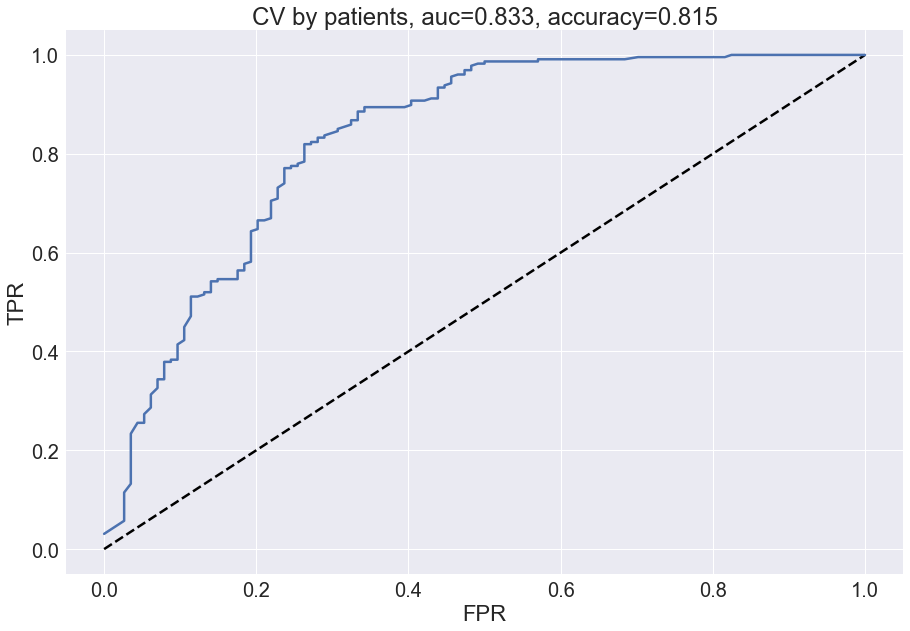

In [52]:
trials = Trials()
best_params_all = optimize(X, y, patients, trials, cv_type='patient', model_type='rf', metric='auc', max_evals=250)

patient_cv(X, y, patients, 'rf', best_params_all)

In [66]:
trials = Trials()
best_params_pat = optimize(X, y, patients, trials, cv_type='patient', model_type='rf')

# patient_cv(X, y, patients, 'xgb', best_params_all)

In [67]:
trials = Trials()
best_params_simple = optimize(X, y, patients, trials, model_type='rf', cv_type='simple')

(0.0, 1.0)

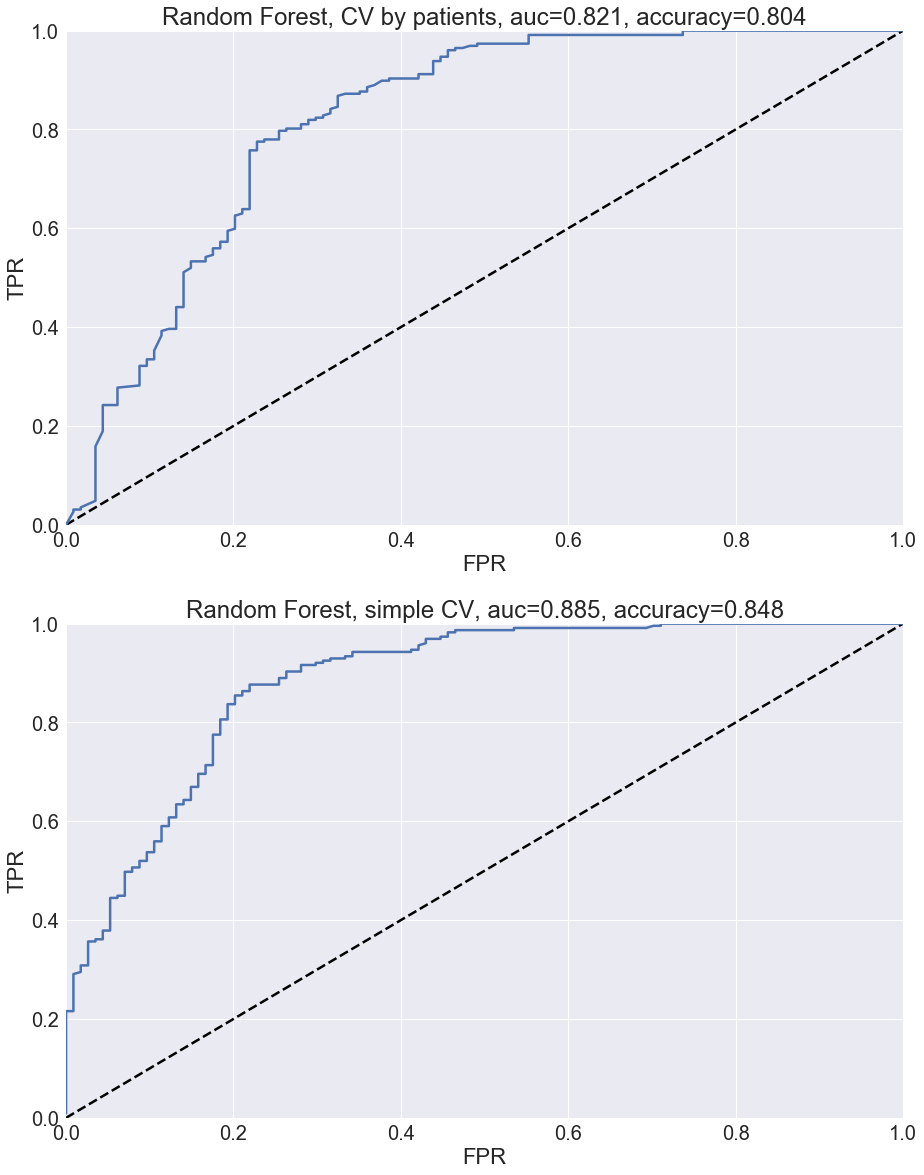

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,20))

st_acc, st_auc = patient_cv(X, y, patients, 'rf', best_params_all, ax=ax1)
burst_acc, burst_auc = simple_cv(X, y, patients, 'rf', best_params_simple, ax=ax2)

ax1.set_title('Random Forest, CV by patients, auc={}, accuracy={}'.format(round(st_auc, 3), round(st_acc, 3)))
ax2.set_title('Random Forest, simple CV, auc={}, accuracy={}'.format(round(burst_auc, 3), round(burst_acc, 3)))
# ax3.set_title('Random Forest, all features, auc={}, accuracy={}'.format(round(all_auc, 3), round(all_acc, 3)))

ax1.set_xlim([0., 1.])
ax1.set_ylim([0., 1.])
ax2.set_xlim([0., 1.])
ax2.set_ylim([0., 1.])

In [80]:
trials = Trials()
xgb_pat = optimize(X, y, patients, trials, model_type='xgb', cv_type='patient')

# patient_cv(X_spiketrain, y, patients, 'xgb', best_params_spiketrain)

In [81]:
trials = Trials()
xgb_cv = optimize(X, y, patients, trials, model_type='xgb', cv_type='simple')

# patient_cv(X_burst, y, patients, 'xgb', best_params_burst)

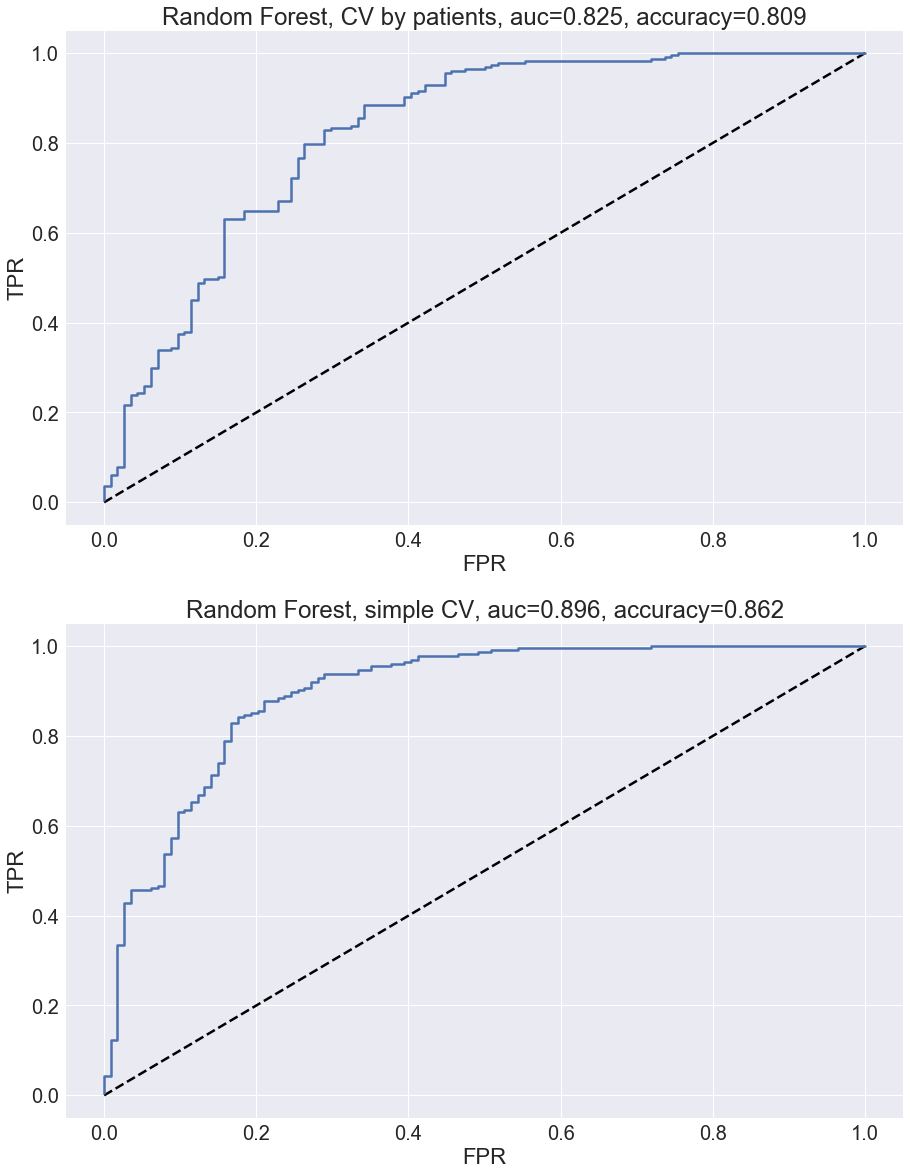

In [82]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,20))

st_acc, st_auc = patient_cv(X, y, patients, 'xgb', xgb_pat, ax=ax1)
burst_acc, burst_auc = simple_cv(X, y, patients, 'xgb', xgb_cv, ax=ax2)

ax1.set_title('Random Forest, CV by patients, auc={}, accuracy={}'.format(round(st_auc, 3), round(st_acc, 3)))
ax2.set_title('Random Forest, simple CV, auc={}, accuracy={}'.format(round(burst_auc, 3), round(burst_acc, 3)))

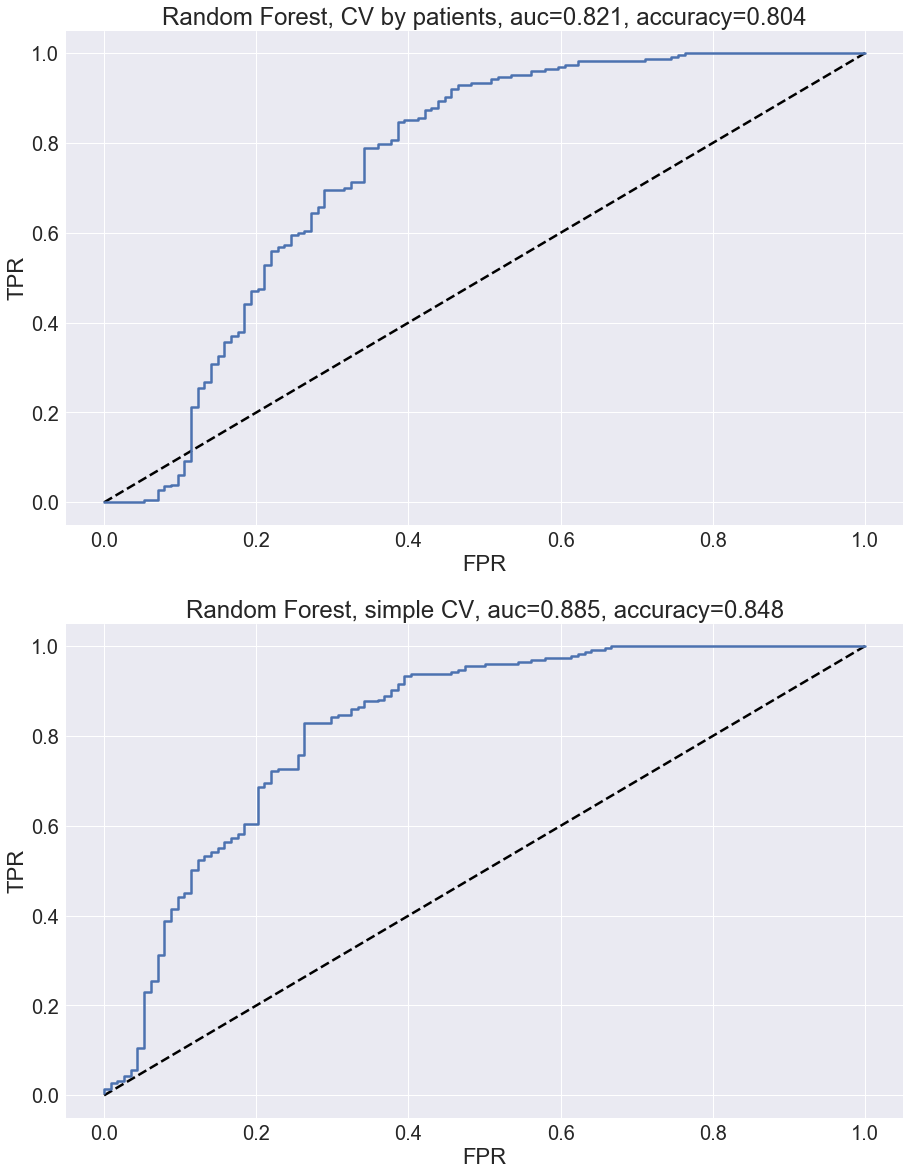

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,20))

acc, auc_score = patient_cv(X, y, patients, 'linear', best_params_all, ax=ax1)
ax1.set_title('Linear model, CV by patients, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

acc, auc_score = simple_cv(X, y, patients, 'linear', best_params_all, ax=ax2)
ax2.set_title('Linear model, simple CV, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

# acc, auc_score = patient_cv(X, y, patients, 'linear', best_params_all, ax=ax3)
# ax3.set_title('Linear model, all features, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

ax1.set_title('Random Forest, CV by patients, auc={}, accuracy={}'.format(round(st_auc, 3), round(st_acc, 3)))
ax2.set_title('Random Forest, simple CV, auc={}, accuracy={}'.format(round(burst_auc, 3), round(burst_acc, 3)))

In [86]:
data.to_csv('without_burst_oscore.csv', index=False)

In [147]:
for c, idx in zip(old_cols, data.columns.values):
    print('X{} : {}'.format(idx, c))

X1 : AI
X2 : burst_spike_percent
X3 : cv
X4 : firing_rate
X5 : frequency_variance
X6 : isi_mean
X7 : isi_median
X8 : isi_std
X9 : isi_larger_than_mean
X10 : kurtoisis
X11 : skewness
X12 : lv
X13 : nu
X14 : oscore_12.0_20.0
X15 : oscore_20.0_30.0
X16 : oscore_3.0_8.0
X17 : oscore_30.0_60.0
X18 : oscore_60.0_90.0
X19 : oscore_8.0_12.0
X20 : interburst_interval
X21 : mean_isi_in_burst
X22 : median_isi_in_burst
X23 : mean_spikes_in_burst
X24 : burst_oscore_12.0_20.0
X25 : burst_oscore_20.0_30.0
X26 : burst_oscore_3.0_8.0
X27 : burst_oscore_30.0_60.0
X28 : burst_oscore_60.0_90.0
X29 : burst_oscore_8.0_12.0
X30 : burst_index
X31 : pause_index
X32 : modalirity_burst
X33 : bi_2
X34 : burst_behaviour
X35 : pause_ratio
X36 : awake
